## Лабораторная работа № 2 по глубокому обучению

### Реализация нейронной сети прямого распространения с использованием библиотеки TensorFlow 2

#### Цель и задачи работы:
1. Изучить способы подготовки данных для нейронной сети.
2. Рассмотреть принципы создания нейросетей с использованием TensorFlow и Keras.
3. Познакомиться со средой визуализации TensorBoard.
4. Получить навыки создания, настройки гиперпараметров нейронных сетей прямого распростанения и анализа табличных данных с их помощью.
5. Получить навыки анализа результатов работы нейронной сети.



#### Постановка задачи
В данной работе требуется проанализировать датасет [с ценами на дома в Бангалоре](https://www.kaggle.com/shantanudhakadd/house-prediction-dataset). Данный датасет представлен файлом ``Bengaluru_House_Data.csv``. Необходимо создать нейросеть прямого распространения (состоящую их полносвязных слоев и слоев активации), позволяющую предсказывать цену дома на основании его характеристик, представленных в датасете. Требуется получить значения метрик качества RMSE и $R^2$ (коэффициент детерминации) и настроить нейросеть для достижения как можно более высоких значений метрик. Результаты работы нужно представить в виде оформленного ноутбука.

#### Загрузка данных и подготовка признаков для нейросети



Установим плагин ``tensorboard-plugin-profile``, позволяющий выполнять профилировку нейросетевого приложения.

In [337]:
# !pip install -U tensorflow tensorboard-plugin-profile
# !pip install plotly
# !pip install seaborn
# !pip install sklearn
# !pip install scikit-learn

In [338]:
#from google.colab import drive
#drive.mount('/content/drive')

Установим необходимые для работы библиотеки, разрешим использование TensorBoard в ноутбуке и определим количество доступных графических ускорителей.

In [339]:
import glob
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

#%load_ext tensorboard
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

Num GPUs Available:  1


Загрузим датасет из текстового файла в датафрейм библиотеки Pandas для последующего анализа.

In [340]:
df = pd.read_csv('Bengaluru_House_Data.csv')

Посмотрим на фрагмент загруженного датасета.

In [341]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


Видно, что данные весьма разнородны: имеются и текстовые значения, и целочисленные, и с плавающей точкой. Также, можно наблюдать пропуски в ячейках (значения "Not A Number" (``NaN``)). Очевидно, что такие данные без подготовки подать на вход нейросети не получится. Их нужно предобработать.

В большинстве случаев, процесс подготовки признаков схож с таковым для линейной и логистической регрессий, поскольку первый слой нейросети может интерпретироваться как модель регрессии. Посмотрим на характеристику столбцов датафрейма с помощью метода ``info()``

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


Видно, что последние три столба определились как числовые, а остальные представлены в нераспознанном формате. Судя по названиям столбцов и примерам представленных в них данных, все стобцы могут содержать либо ``количественные``, либо ``категориальные`` данные, что и определит способ преобразования этих данных. Определим количество нулевых значений в столбцах.


In [343]:
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

#### Разбиение обучающей выборки на `train` и `test`

Разобъем все множество объктов обучающей выборки на тренировочное и тестовое непересекающиеся подмножества:

In [344]:
target = "price"
features = df.columns.tolist()
features.remove(target)

X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.3)

In [345]:
features

['area_type',
 'availability',
 'location',
 'size',
 'society',
 'total_sqft',
 'bath',
 'balcony']

Посмотрим на данные в столбцах подробнее.

#### Подготовка значений столбца ``area_type``

Определим количество различных значений столбца с помощью метода ``value_counts()``

In [346]:
df["area_type"].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

Видно, что столбец содержит только четыре различных значения. Они характеризуют тип застраиваемого под дом земельного участка. Поэтому, ``area_type`` -- полноценный категориальный признак. Для линейной регрессии такие признаки принято кодировать с помощью ``one-hot encoding``. При этом, так как полученные в ходе кодирования бинарные признаки являются линейно зависимыми (поскольку их сумма для каждого объекта равна единице), один из них можно убрать без ущерба для кодируемых данных. Выполним такое кодирование столбца с помощью класса [``OneHotEncoder``](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) библиотеки Scikit-Learn.

В библиотеке Scikit-Learn преобразование признаков осуществляется с помощью трансформеров. Трансформер -- это класс, реализующий метод `transform()`, который позволяет выполнить заданные преобразования над набором данных. Чаще всего, выполнение преобразования требует наличия некоторых переменных, которые предварительно должны быть рассчитаны по датасету (например, минимальное и максимальное значения для масштабирования). Класс, позволяющий рассчитать такие переменные по входным данным (другими словами, выполнить "обучение" на данных) называется эстиматором. Он реализует метод `fit()`, выполняющий обучение. Многие трансформеры являются также эстиматорами, т.е. они могут обучить внутренние параметры на некотором входном датасете, а потом выполнить трансформацию данного датасета или любого другого. Подробнее можно узнать в [документации](https://scikit-learn.org/stable/developers/develop.html).

**Обратите внимание**, что эстиматоры обучаются на тренировочном датасете, а затем применяются и к тренировочному, и к тестовому датасету. Это гарантирует факт того, что признаки в обоих датасетах будут преобразованы одинаково.

Создадим функцию, выполняющую `one-hot`-кодирование категориальных признаков:

In [347]:
def ohe_data(train_data, test_data, columns):
    ohe = OneHotEncoder(handle_unknown='ignore', 
                        drop='first',
                        sparse_output=False).fit(X_train[columns])
    temp_train_data = train_data.copy()
    temp_test_data = test_data.copy()

    temp_train_data[ohe.get_feature_names_out()] = ohe.transform(
        train_data[columns]
    )
    temp_test_data[ohe.get_feature_names_out()] = ohe.transform(
        test_data[columns]
    )

    return (temp_train_data.drop(columns, axis=1),
            temp_test_data.drop(columns, axis=1))

In [348]:
X_train, X_test = ohe_data(X_train, X_test, ["area_type"])

In [349]:
X_train

,availability,location,size,society,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
754,Ready To Move,Thanisandra,2 BHK,MenueNo,1185,2.0,2.0,0.0,0.0,1.0
1637,Ready To Move,Ramamurthy Nagar,2 Bedroom,NaN,1200,3.0,1.0,0.0,1.0,0.0
7441,Ready To Move,Mallasandra,4 BHK,Shbhi S,1810,3.0,2.0,0.0,0.0,0.0
11905,18-May,Electronic City Phase II,3 BHK,Sryalan,1310,2.0,1.0,0.0,0.0,1.0
2945,Ready To Move,Hagadur,2 BHK,SSoraba,1110,2.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
8441,Ready To Move,Kanakpura Road,3 BHK,PuandHi,1843,3.0,2.0,0.0,0.0,1.0
4238,Ready To Move,Laggere,4 Bedroom,NaN,1260,4.0,1.0,0.0,1.0,0.0
1714,Ready To Move,R.T. Nagar,2 Bedroom,NaN,1200,2.0,1.0,0.0,1.0,0.0
8862,Ready To Move,Gubbalala,2 BHK,MauilTr,1475,2.0,2.0,0.0,0.0,1.0


#### Подготовка значений столбца ``availability``

Выведем список **всех** различных значений, которые может принимать столбец.

In [350]:
df["availability"].value_counts().index

Index(['Ready To Move', '18-Dec', '18-May', '18-Apr', '18-Aug', '19-Dec',
       '18-Jul', '18-Mar', '18-Jun', '20-Dec', '21-Dec', '19-Mar', '18-Feb',
       '18-Nov', '18-Jan', '18-Sep', '19-Jun', '18-Oct', '19-Jan', '19-Jul',
       '17-Dec', '20-Jan', '17-Oct', '19-Sep', '22-Jun', '19-Aug', '21-Jun',
       '19-Apr', 'Immediate Possession', '20-Aug', '19-Oct', '21-Mar',
       '17-Jun', '21-May', '17-Jul', '17-Nov', '21-Jan', '22-Dec', '20-Jun',
       '17-Sep', '22-May', '19-May', '17-Aug', '21-Jul', '17-May', '20-Oct',
       '19-Nov', '17-Apr', '21-Feb', '20-Sep', '21-Oct', '22-Jan', '21-Sep',
       '21-Aug', '20-Jul', '17-Mar', '20-Nov', '16-Dec', '20-Apr', '20-May',
       '21-Nov', '16-Mar', '22-Mar', '19-Feb', '20-Mar', '22-Nov', '16-Sep',
       '15-Oct', '17-Feb', '15-Nov', '20-Feb', '15-Jun', '16-Jul', '14-Nov',
       '15-Dec', '16-Oct', '15-Aug', '17-Jan', '16-Nov', '16-Jan', '14-Jul'],
      dtype='object')

Видно, что столбец принимает одно из трех типов значений:

* Ready To Move
* Immediate Possession
* Месяц и год, когда к дом можно переехать

Данный столбец тоже содержит категориальный признак. Однако, количество значений весьма велико, при этом некоторые из значений встречаются очень редко. Более того, существенная часть значений признаков -- это даты, на которых определена операция частичного порядка. Поэтому, данный признак можно попытаться обработать следующим образом. Введем три дополнительных признака:

* бинарный признак, отвечающий за равенство значения признака соответствующего объекта значению "Ready To Move".
* бинарный признак, отвечающий за равенство значения признака соответствующего объекта значению "Immediate Possession".
* Количественный признак, соответствующий Timestamp-метке соотвествующей даты.

Для каждого признака, разумеется, может быть отличным от нуля только один признак. Выполним такую обработку признака. Один из способов, которым это можно сделать, заключается в написании пользовательской функции, выполняющей условную обработку разных значений признака, и ее использование в методе ``df.apply()``.

In [351]:
import datetime
def parse_availability(row):
    value = row.loc["availability"]
    if value == "Ready To Move":
        return (int(1), int(0), np.nan)
    elif value == "Immediate Possession":
        return (int(0), int(1), np.nan)
    else:
        date = datetime.datetime.strptime(value, "%y-%b")
        return (int(0), int(0), datetime.datetime.timestamp(date))

In [352]:
X_train[["avail_ready", "avail_imm", "avail_time"]] = X_train.apply(
    parse_availability, axis=1, result_type='expand'
)
X_train = X_train.drop(["availability"], axis=1)

X_test[["avail_ready", "avail_imm", "avail_time"]] = X_test.apply(
    parse_availability, axis=1, result_type='expand'
)
X_test = X_test.drop(["availability"], axis=1)

In [353]:
X_train

,location,size,society,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time
754,Thanisandra,2 BHK,MenueNo,1185,2.0,2.0,0.0,0.0,1.0,1.0,0.0,NaN
1637,Ramamurthy Nagar,2 Bedroom,NaN,1200,3.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN
7441,Mallasandra,4 BHK,Shbhi S,1810,3.0,2.0,0.0,0.0,0.0,1.0,0.0,NaN
11905,Electronic City Phase II,3 BHK,Sryalan,1310,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.525122e+09
2945,Hagadur,2 BHK,SSoraba,1110,2.0,2.0,0.0,0.0,1.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8441,Kanakpura Road,3 BHK,PuandHi,1843,3.0,2.0,0.0,0.0,1.0,1.0,0.0,NaN
4238,Laggere,4 Bedroom,NaN,1260,4.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN
1714,R.T. Nagar,2 Bedroom,NaN,1200,2.0,1.0,0.0,1.0,0.0,1.0,0.0,NaN
8862,Gubbalala,2 BHK,MauilTr,1475,2.0,2.0,0.0,0.0,1.0,1.0,0.0,NaN


Разработанная выше функция добавила в датасет пропущенные значения (`NaN`). Заменим их медианным значением с помощью трансформера `SimpleImputer`:

In [354]:
imp_median = SimpleImputer(missing_values=np.nan, 
                         strategy="median").fit(X_train[["avail_time"]])
X_train["avail_time"] = imp_median.transform(X_train[["avail_time"]])
X_test["avail_time"] = imp_median.transform(X_test[["avail_time"]])

In [355]:
X_train

,location,size,society,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time
754,Thanisandra,2 BHK,MenueNo,1185,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.533071e+09
1637,Ramamurthy Nagar,2 Bedroom,NaN,1200,3.0,1.0,0.0,1.0,0.0,1.0,0.0,1.533071e+09
7441,Mallasandra,4 BHK,Shbhi S,1810,3.0,2.0,0.0,0.0,0.0,1.0,0.0,1.533071e+09
11905,Electronic City Phase II,3 BHK,Sryalan,1310,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.525122e+09
2945,Hagadur,2 BHK,SSoraba,1110,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.533071e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
8441,Kanakpura Road,3 BHK,PuandHi,1843,3.0,2.0,0.0,0.0,1.0,1.0,0.0,1.533071e+09
4238,Laggere,4 Bedroom,NaN,1260,4.0,1.0,0.0,1.0,0.0,1.0,0.0,1.533071e+09
1714,R.T. Nagar,2 Bedroom,NaN,1200,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.533071e+09
8862,Gubbalala,2 BHK,MauilTr,1475,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.533071e+09


Посмотрим на распределение значений последнего введенного признака (количественного) с помощью метода ``Series.hist()``.

<AxesSubplot:>

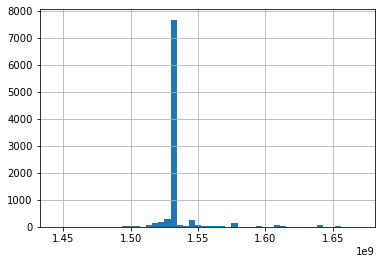

In [356]:
X_train["avail_time"].hist(bins=50)

Его значения лежат в районе миллиардов, что затруднит работу нейросети. Такие количесвенные признаки подлежат масштабированию (``MinMaxScaler()``) или нормировке (``StandardScaler()``). Создадим функцию для нормировки количественных признаков с помощью трансформера `StandardScaler`:

In [357]:
def scale_std(train_data, test_data, columns):
    scaler = StandardScaler().fit(X_train[columns])

    temp_train_data = train_data.copy()
    temp_test_data = test_data.copy()

    scaler.fit(temp_train_data[columns])

    temp_train_data[columns] = scaler.transform(
        temp_train_data[columns]
    )
    temp_test_data[columns] = scaler.transform(
        temp_test_data[columns]
    )
    return temp_train_data, temp_test_data

In [358]:
X_train, X_test = scale_std(X_train, X_test, ["avail_time"])

In [359]:
X_train

,location,size,society,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time
754,Thanisandra,2 BHK,MenueNo,1185,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968
1637,Ramamurthy Nagar,2 Bedroom,NaN,1200,3.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968
7441,Mallasandra,4 BHK,Shbhi S,1810,3.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968
11905,Electronic City Phase II,3 BHK,Sryalan,1310,2.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750
2945,Hagadur,2 BHK,SSoraba,1110,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968
...,...,...,...,...,...,...,...,...,...,...,...,...
8441,Kanakpura Road,3 BHK,PuandHi,1843,3.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968
4238,Laggere,4 Bedroom,NaN,1260,4.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968
1714,R.T. Nagar,2 Bedroom,NaN,1200,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968
8862,Gubbalala,2 BHK,MauilTr,1475,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968


<AxesSubplot:>

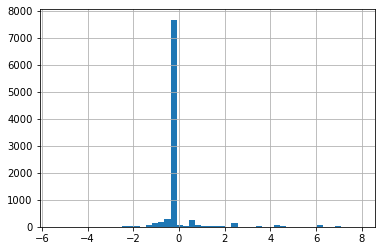

In [360]:
X_train["avail_time"].hist(bins=50)

#### Подготовка значений столбца ``location``

Определим количество различных значений столбца и построим их распределение.

<AxesSubplot:>

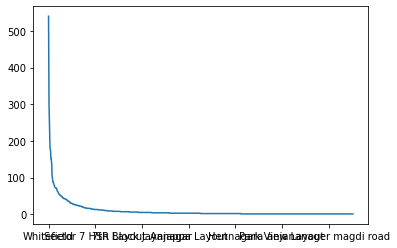

In [361]:
df["location"].value_counts().plot()

In [362]:
df["location"].value_counts().index

Index(['Whitefield', 'Sarjapur  Road', 'Electronic City', 'Kanakpura Road',
       'Thanisandra', 'Yelahanka', 'Uttarahalli', 'Hebbal', 'Marathahalli',
       'Raja Rajeshwari Nagar',
       ...
       'Vidyapeeta', 'Maruthi Extension', 'Okalipura', 'Old Town',
       'Vasantapura main road', 'Bapuji Layout',
       '1st Stage Radha Krishna Layout', 'BEML Layout 5th stage',
       'singapura paradise', 'Abshot Layout'],
      dtype='object', length=1305)

Видно, что число категорий довольно большое, но многие значения встречаются редко. Если закодировать их с помощью `one-hot`, то итоговый датасет будет содержать большое количество разреженных признаков, что негативно скажется на обучении модели.

В таком случае, можно поступить следующим образом. Выполним **частотное** кодирование категориальных признаков, при котором каждому признаку ставится в соответствие число: сколько раз этот признак встречался в тренировочном датасете.

Признак `location` содержит пропущенные значения. Будем считать объекты, у которых не установлен признак, входящими в отдельную категорию. Реализуем функцию, которая каждое пропущенное значение заменяет на некоторую предопределенную категорию.

In [363]:
def encode_cat_nans(train_data, test_data, columns, fill_value="Absent_value"):
    imp_const = SimpleImputer(missing_values=np.nan, 
                              strategy='constant', 
                              fill_value=fill_value)
    temp_train_data = train_data.copy()
    temp_test_data = test_data.copy()

    imp_const.fit(temp_train_data[columns])

    temp_train_data[columns] = imp_const.transform(
        temp_train_data[columns]
    )
    temp_test_data[columns] = imp_const.transform(
        temp_test_data[columns]
    )
    return temp_train_data, temp_test_data

Реализуем функцию частотного кодирования признака.

In [364]:
def freq_encoding(train_data, test_data, column):
    encodings = train_data.groupby(column)[[column]].count()
    temp_train_data = train_data.join(
        encodings,
        on=column,
        lsuffix="_left",
        rsuffix=""
    ).drop(column + "_left", axis=1)

    temp_test_data = test_data.join(
        encodings,
        on=column,
        lsuffix="_left",
        rsuffix=""
    ).drop(column + "_left", axis=1)

    temp_test_data[column] = temp_test_data[column].fillna(value=0)

    return temp_train_data, temp_test_data

Выполним преобразование признаков с последующей нормировкой их значений.

In [365]:
X_train, X_test = encode_cat_nans(X_train, X_test, ["location"])
X_train, X_test = freq_encoding(X_train, X_test, "location")
X_train, X_test = scale_std(X_train, X_test, ["location"])

In [366]:
X_train

,size,society,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location
754,2 BHK,MenueNo,1185,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742
1637,2 Bedroom,NaN,1200,3.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102
7441,4 BHK,Shbhi S,1810,3.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798
11905,3 BHK,Sryalan,1310,2.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023
2945,2 BHK,SSoraba,1110,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329
...,...,...,...,...,...,...,...,...,...,...,...,...
8441,3 BHK,PuandHi,1843,3.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907
4238,4 Bedroom,NaN,1260,4.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554
1714,2 Bedroom,NaN,1200,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716
8862,2 BHK,MauilTr,1475,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471


#### Подготовка значений столбца ``size``

Определим количество различных значений столбца и построим их распределение.

In [367]:
df["size"].value_counts()

2 BHK         5199
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 BHK           2
11 Bedroom       2
10 BHK           2
14 BHK           1
13 BHK           1
12 Bedroom       1
27 BHK           1
43 Bedroom       1
16 BHK           1
19 BHK           1
18 Bedroom       1
Name: size, dtype: int64

<AxesSubplot:>

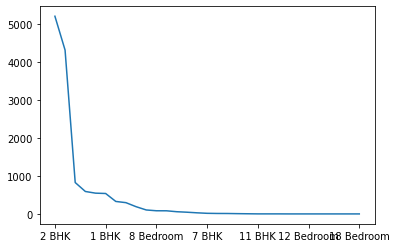

In [368]:
df["size"].value_counts().plot()

Видно, что ситуация схожа с признаком ``location``. Поэтому, обработаем его таким же образом.

In [369]:
X_train, X_test = encode_cat_nans(X_train, X_test, ["size"])
X_train, X_test = freq_encoding(X_train, X_test, "size")
X_train, X_test = scale_std(X_train, X_test, ["size"])

In [370]:
X_train

,society,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location,size
754,MenueNo,1185,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742,0.809650
1637,NaN,1200,3.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102,-1.649207
7441,Shbhi S,1810,3.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798,-1.515926
11905,Sryalan,1310,2.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023,0.385312
2945,SSoraba,1110,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329,0.809650
...,...,...,...,...,...,...,...,...,...,...,...,...
8441,PuandHi,1843,3.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907,0.385312
4238,NaN,1260,4.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554,-1.399215
1714,NaN,1200,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716,-1.649207
8862,MauilTr,1475,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471,0.809650


In [371]:
# Ваш код

#### Подготовка значений столбца ``society``

Определим количество различных значений столбца и построим их распределение.

In [372]:
df["society"].value_counts() # 

GrrvaGr    80
PrarePa    76
Sryalan    59
Prtates    59
GMown E    56
           ..
Amionce     1
JaghtDe     1
Jauraht     1
Brity U     1
RSntsAp     1
Name: society, Length: 2688, dtype: int64

И вновь можно заметить, что ситуация схожа с признаком ``location``. Обрабатываем и этот признак аналогичным образом.



In [373]:
X_train, X_test = encode_cat_nans(X_train, X_test, ["society"])
X_train, X_test = freq_encoding(X_train, X_test, "society")
X_train, X_test = scale_std(X_train, X_test, ["society"])

In [374]:
X_train

,total_sqft,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location,size,society
754,1185,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742,0.809650,-0.822135
1637,1200,3.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102,-1.649207,1.204604
7441,1810,3.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798,-1.515926,-0.833395
11905,1310,2.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023,0.385312,-0.810875
2945,1110,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329,0.809650,-0.833931
...,...,...,...,...,...,...,...,...,...,...,...,...
8441,1843,3.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907,0.385312,-0.824280
4238,1260,4.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554,-1.399215,1.204604
1714,1200,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716,-1.649207,1.204604
8862,1475,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471,0.809650,-0.831250


In [375]:
# Ваш код

#### Подготовка значений столбца ``total_sqft``

Определим количество различных значений столбца.

In [376]:
df["total_sqft"].value_counts() # 

1200    843
1100    221
1500    205
2400    196
600     180
       ... 
3580      1
2461      1
1437      1
2155      1
4689      1
Name: total_sqft, Length: 2117, dtype: int64

Выведем **все** различные значения этого столбца.

In [377]:
ll = df["total_sqft"].value_counts().index.tolist()
for i in ll:
    print(i)

1200
1100
1500
2400
600
1000
1350
1050
1300
1250
900
1400
1800
1150
1600
1140
2000
1450
1650
800
3000
1075
1020
2500
1550
1160
1125
950
1180
1700
1260
1255
1220
1080
1070
700
750
1225
4000
1175
1320
1240
2100
1230
1060
1210
850
1280
1270
1185
1190
1170
1410
1750
1330
1025
1290
1310
1850
1065
1194
1090
1215
500
1360
2700
1115
1900
3500
1120
1464
1530
1205
1340
2200
1430
1035
1560
1165
1128
3600
1130
1145
1275
2800
1355
1040
1155
1105
1680
1420
1460
650
1760
1590
1216
1245
1010
1305
1475
2600
883
1440
1030
1575
1110
1495
985
1246
3200
1243
1385
1470
525
1027
1015
1370
1315
1610
5000
1325
925
660
1480
550
1390
1540
1570
1365
1645
1640
1265
920
1520
1525
1196
1195
980
1012
1095
975
4800
1485
940
2072
1345
1820
1665
960
1157
1232
1375
400
1295
1490
1830
3300
1655
645
1235
1197
935
2300
1720
1425
1045
1418
1135
630
1152
1285
1153
1380
1740
4500
1116
1580
1660
1085
1920
1950
1141
1630
675
1445
450
1595
720
905
2250
840
1730
1690
1710
3800
3900
1625
2215
1875
1282
970
1510
1082
1314
1535
1005


Можно заметить, что данный столбец содержит пример так называемых "грязных" данных. Значение в столбце может быть либо числом, либо интервалом чисел, либо числом с единицей измерения, причем единиц измерения много...

Определим количество значений признака, относящихся к каждой из этих групп. Здесь вновь поможет метод ``Series.apply()`` с функцией, проверяющей условие принадлежности признака к нужной группе; принадлежность можно установить с помощью регулярных выражений.

In [378]:
import re

def is_number(row):
    return re.match(r"^[0-9\s]+$", row)

def is_interval(row):
    return re.match(r"^[0-9\s]+-[0-9\s]+$", row)

def is_units(row):
    return re.search(r"[^0-9-\s]", row)

print( df["total_sqft"].apply(is_number).count() )
print( df["total_sqft"].apply(is_interval).count() )
print( df["total_sqft"].apply(is_units).count() )

12986
196
138


Видно, что количество значений признака, представленных числом с единицей измерения, меньше других. Из-за большой трудоемкости обработки таких значений их целесообразно удалить (их не столь много, чтобы значительно повлиять на объем датасета). Далее, создадим два вспомогательных признака, обозначающих начало и конец интервала и заполним их (если значение признака содержит не интервал, а число, будем считать, что начало и конец интервала равны этому числу).

In [379]:
import re
def parse_interval(row):
    if not re.search("[^0-9-.\s]", row.loc["total_sqft"]):  
        res = row.loc["total_sqft"].split("-")
        beg = float(res[0])
        end = float(res[0]) if len(res) == 1 else float(res[1])
        return (beg, end)
    return (0, 0)

In [380]:
X_train[["sqft_beg", "sqft_end"]] = X_train.apply(
    parse_interval, axis=1, result_type='expand'
)
X_train = X_train.drop(["total_sqft"], axis=1)

X_test[["sqft_beg", "sqft_end"]] = X_test.apply(
    parse_interval, axis=1, result_type='expand'
)
X_test = X_test.drop(["total_sqft"], axis=1)

In [381]:
X_train

,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location,size,society,sqft_beg,sqft_end
754,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742,0.809650,-0.822135,1185.0,1185.0
1637,3.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102,-1.649207,1.204604,1200.0,1200.0
7441,3.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798,-1.515926,-0.833395,1810.0,1810.0
11905,2.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023,0.385312,-0.810875,1310.0,1310.0
2945,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329,0.809650,-0.833931,1110.0,1110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8441,3.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907,0.385312,-0.824280,1843.0,1843.0
4238,4.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554,-1.399215,1.204604,1260.0,1260.0
1714,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716,-1.649207,1.204604,1200.0,1200.0
8862,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471,0.809650,-0.831250,1475.0,1475.0


Построим гистограммы распределения новых двух признаков.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sqft_beg', ylabel='Density'>

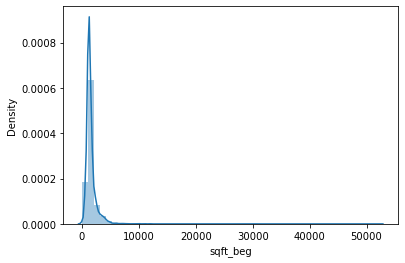

In [382]:
sns.distplot(X_train["sqft_beg"])

<AxesSubplot:>

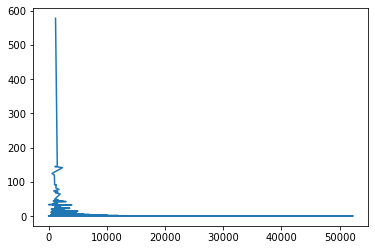

In [383]:
X_train["sqft_beg"].value_counts().plot()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sqft_end', ylabel='Density'>

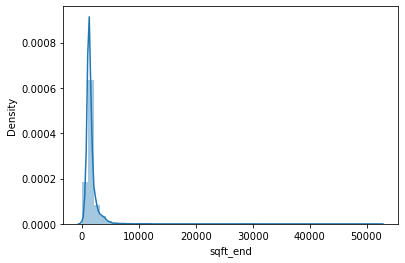

In [384]:
sns.distplot(X_train["sqft_end"])

<AxesSubplot:>

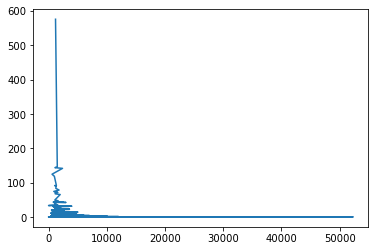

In [385]:
X_train["sqft_end"].value_counts().plot()

Видно, что новые количественные признаки имеют очень большой диапазон. Прологарифмируем их, перейдя от значений к их **порядкам**.

In [386]:
X_train["sqft_beg"] = np.log1p(X_train["sqft_beg"])
X_train["sqft_beg"] = X_train["sqft_beg"] - X_train["sqft_beg"].mean()

X_train["sqft_end"] = np.log1p(X_train["sqft_end"])
X_train["sqft_end"] = X_train["sqft_end"] - X_train["sqft_end"].mean()

X_test["sqft_beg"] = np.log1p(X_test["sqft_beg"])
X_test["sqft_beg"] = X_test["sqft_beg"] - X_test["sqft_beg"].mean()

X_test["sqft_end"] = np.log1p(X_test["sqft_end"])
X_test["sqft_end"] = X_test["sqft_end"] - X_test["sqft_end"].mean()

In [387]:
X_train

,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location,size,society,sqft_beg,sqft_end
754,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742,0.809650,-0.822135,-0.125400,-0.128325
1637,3.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102,-1.649207,1.204604,-0.112832,-0.115757
7441,3.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798,-1.515926,-0.833395,0.297892,0.294968
11905,2.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023,0.385312,-0.810875,-0.025196,-0.028121
2945,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329,0.809650,-0.833931,-0.190726,-0.193651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8441,3.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907,0.385312,-0.824280,0.315950,0.313026
4238,4.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554,-1.399215,1.204604,-0.064082,-0.067007
1714,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716,-1.649207,1.204604,-0.112832,-0.115757
8862,2.0,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471,0.809650,-0.831250,0.093349,0.090424


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sqft_beg', ylabel='Density'>

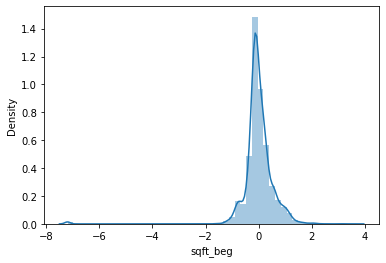

In [388]:
sns.distplot(X_train["sqft_beg"])

<AxesSubplot:>

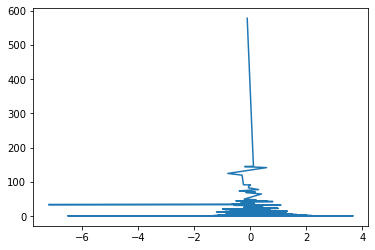

In [389]:
X_train["sqft_beg"].value_counts().plot()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sqft_end', ylabel='Density'>

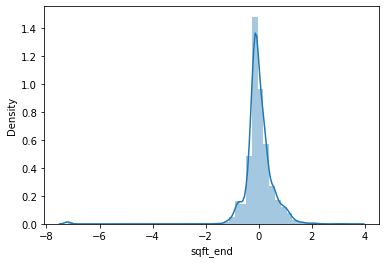

In [390]:
sns.distplot(X_train["sqft_end"])

#### Подготовка значений столбца ``bath``

Данный признак содержит пропущенные значения. Их немного, просто удалим объекты с пропущенными значениями признака.


In [391]:
df = df[df["bath"].notna()]
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


Определим количество различных значений столбца.

In [392]:
df["bath"].value_counts()

2.0     6908
3.0     3286
4.0     1226
1.0      788
5.0      524
6.0      273
7.0      102
8.0       64
9.0       43
10.0      13
12.0       7
13.0       3
11.0       3
16.0       2
27.0       1
40.0       1
15.0       1
14.0       1
18.0       1
Name: bath, dtype: int64

<AxesSubplot:>

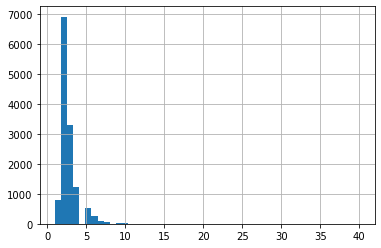

In [393]:
df["bath"].hist(bins=50)

In [394]:
# Ваш код

Данный признак можно считать количественным. У него есть выбросы, которые нужно обработать. На основании распределения признака, будем считать, что количество ванн, большее чем 10, встречается редко. Поэтому, все значения признака, большие 10, заменим числом 10 (т.е., будем считать, что для покупателя нет разницы, сколько ванн больше 10 будет, все равно их много).

In [395]:
X_train["bath"] = X_train["bath"].apply(lambda x: x if x < 10.0 else 10.0)
X_test["bath"] = X_test["bath"].apply(lambda x: x if x < 10.0 else 10.0)

Построим гистрограмму распределения признака и на ее основе подберем метод масштабирования / нормировки. Применим его к признаку.

<AxesSubplot:>

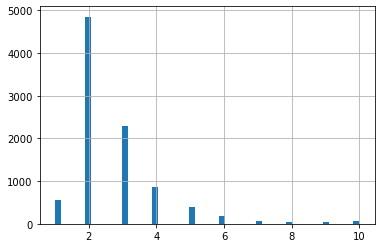

In [396]:
X_train["bath"].hist(bins=50)

In [397]:
X_train, X_test = scale_std(X_train, X_test, ["bath"])
X_train

,bath,balcony,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location,size,society,sqft_beg,sqft_end
754,-0.532717,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742,0.809650,-0.822135,-0.125400,-0.128325
1637,0.208302,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102,-1.649207,1.204604,-0.112832,-0.115757
7441,0.208302,2.0,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798,-1.515926,-0.833395,0.297892,0.294968
11905,-0.532717,1.0,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023,0.385312,-0.810875,-0.025196,-0.028121
2945,-0.532717,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329,0.809650,-0.833931,-0.190726,-0.193651
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8441,0.208302,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907,0.385312,-0.824280,0.315950,0.313026
4238,0.949321,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554,-1.399215,1.204604,-0.064082,-0.067007
1714,-0.532717,1.0,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716,-1.649207,1.204604,-0.112832,-0.115757
8862,-0.532717,2.0,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471,0.809650,-0.831250,0.093349,0.090424


In [398]:
# Ваш код

#### Подготовка значений столбца ``balcony``

Данный признак содержит пропущенные значения. Заменим их значением -1.0.

In [399]:
X_train["balcony"]


754      2.0
1637     1.0
7441     2.0
11905    1.0
2945     2.0
        ... 
8441     2.0
4238     1.0
1714     1.0
8862     2.0
4548     1.0
Name: balcony, Length: 9324, dtype: float64

In [400]:
X_train["balcony"].value_counts()

2.0    3613
1.0    3438
3.0    1173
0.0     684
Name: balcony, dtype: int64

In [401]:
X_Train_test = X_train.copy()
X_Train_test["balcony"].value_counts()

2.0    3613
1.0    3438
3.0    1173
0.0     684
Name: balcony, dtype: int64

In [402]:
X_train["balcony"] = X_Train_test["balcony"].apply(lambda x: x if x >= 0.0 else -1.0)

In [403]:
# Ваш код

Определим количество различных значений столбца.

In [404]:
# Ваш код

X_train["balcony"].value_counts()

 2.0    3613
 1.0    3438
 3.0    1173
 0.0     684
-1.0     416
Name: balcony, dtype: int64

Видно, что данный признак можно рассматривать как категориальный. Закодируем его ``one-hot``-кодировкой.

In [405]:
# Ваш код

X_train, X_test = ohe_data(X_train, X_test, ["balcony"])

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [406]:
X_train

,bath,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,avail_ready,avail_imm,avail_time,location,size,society,sqft_beg,sqft_end,balcony_0.0,balcony_1.0,balcony_2.0,balcony_3.0
754,-0.532717,0.0,0.0,1.0,1.0,0.0,-0.162968,1.114742,0.809650,-0.822135,-0.125400,-0.128325,0.0,0.0,1.0,0.0
1637,0.208302,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.189102,-1.649207,1.204604,-0.112832,-0.115757,0.0,1.0,0.0,0.0
7441,0.208302,0.0,0.0,0.0,1.0,0.0,-0.162968,-0.587798,-1.515926,-0.833395,0.297892,0.294968,0.0,0.0,1.0,0.0
11905,-0.532717,0.0,0.0,1.0,0.0,0.0,-0.630750,0.285023,0.385312,-0.810875,-0.025196,-0.028121,0.0,1.0,0.0,0.0
2945,-0.532717,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.706329,0.809650,-0.833931,-0.190726,-0.193651,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8441,0.208302,0.0,0.0,1.0,1.0,0.0,-0.162968,1.394907,0.385312,-0.824280,0.315950,0.313026,0.0,0.0,1.0,0.0
4238,0.949321,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.695554,-1.399215,1.204604,-0.064082,-0.067007,0.0,1.0,0.0,0.0
1714,-0.532717,0.0,1.0,0.0,1.0,0.0,-0.162968,-0.447716,-1.649207,1.204604,-0.112832,-0.115757,0.0,1.0,0.0,0.0
8862,-0.532717,0.0,0.0,1.0,1.0,0.0,-0.162968,-0.555471,0.809650,-0.831250,0.093349,0.090424,0.0,0.0,1.0,0.0


#### Подготовка значений целевой переменной ``price``

Построим гистограмму распределения значений столбца.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

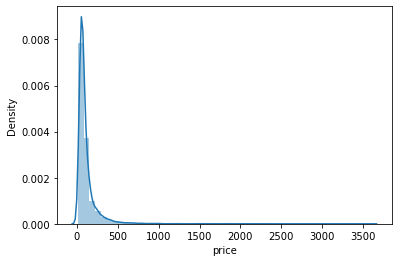

In [407]:
# Ваш код

sns.distplot(df["price"])

<AxesSubplot:>

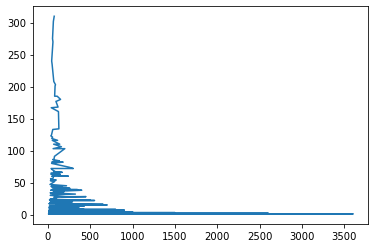

In [408]:
df["price"].value_counts().plot()

In [409]:
df["price"].value_counts()

75.00     310
65.00     302
55.00     275
60.00     270
45.00     240
         ... 
243.00      1
48.24       1
37.95       1
52.66       1
488.00      1
Name: price, Length: 1955, dtype: int64

Расчет среднего аримф меток

In [419]:
lable_sum = 0
for i in  df['price']:
    lable_sum += i

In [420]:
c = lable_sum / len(df['price'])
c

112.38739978863121

In [421]:
# t_sum = 0
# for i in  df['price']:
#     t_sum += i

In [427]:
# rmse = ((sum(c - [i for i in df['price']])**2) / len(df['price']))**0.5
#rmse = (((c - lable_sum)**2) / len(df['price']))**0.5
sum_rmse = 0
for i in  df['price']:
     sum_rmse += ((c - i)**2)
rmse = (sum_rmse / len(df['price']))**0.5
rmse

149.06550913883186

### Формирование ``tf.Dataset()``

Сформируем специальный объект с подготовленными данными, который значительно упрощает их использование в TensorFlow и Keras.

In [326]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train.values, tf.float32),
            tf.cast(y_train.values, tf.float32)
        )
    )
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test.values, tf.float32),
            tf.cast(y_test.values, tf.float32)
        )
    )
)

Зададим размер мини-батча и сформируем батчи данных.

In [327]:
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

### Формирование модели и запуск процессов обучения и валидации

Сформируем модель нейронной сети из слоев.

In [328]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [329]:
# # strategy = tf.distribute.MirroredStrategy()

# # with strategy.scope():
# model = tf.keras.models.Sequential([
#   tf.keras.Input(shape=(len(X_train.columns),), dtype=tf.float32),
  
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.Dense(32, 
#                         #activation='relu',#lrelu
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),#kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
#   tf.keras.layers.LeakyReLU(),
#   #tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#   tf.keras.layers.BatchNormalization(),

#   tf.keras.layers.Dense(32, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.LeakyReLU(),
#   #tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#   tf.keras.layers.BatchNormalization(),

#   tf.keras.layers.Dense(32, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.LeakyReLU(),
#   #tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#   tf.keras.layers.BatchNormalization(),

#   tf.keras.layers.Dense(32, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
#   tf.keras.layers.LeakyReLU(),
#   #tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#   tf.keras.layers.BatchNormalization(),

#   tf.keras.layers.Dense(1, 
#                         activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
# ])



*Новая модель*


In [330]:
# # strategy = tf.distribute.MirroredStrategy()

# # with strategy.scope():
# model = tf.keras.models.Sequential([
#   tf.keras.Input(shape=(len(X_train.columns),), dtype=tf.float32),
  
#     #BatchNormalization
#   tf.keras.layers.BatchNormalization(),
    
#   tf.keras.layers.Dense(32, 
#                         #activation='relu'#lrelu
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),
    
#         #Drop
#   tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),

#   tf.keras.layers.Dense(32, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),

    
#   tf.keras.layers.Dense(512, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),
    
#             #BatchNormalization
#   tf.keras.layers.BatchNormalization(),
    
#   tf.keras.layers.Dense(1024, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),
    
#   tf.keras.layers.Dense(512, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),
    
#   tf.keras.layers.Dense(128, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),

# #   tf.keras.layers.Dense(64, 
# #                         #activation='relu',
# #                         kernel_initializer=tf.keras.initializers.HeNormal(),
# #                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
# #   tf.keras.layers.LeakyReLU(),

#         #Drop
#   tf.keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    
#   tf.keras.layers.Dense(32, 
#                         #activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
#                        ),
#   tf.keras.layers.LeakyReLU(),
    
#   tf.keras.layers.Dense(1, 
#                         activation='relu',
#                         kernel_initializer=tf.keras.initializers.HeNormal(),
#                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
# ])


Double 2

In [331]:
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(len(X_train.columns),), dtype=tf.float32),
  
  tf.keras.layers.Dense(64, 
                        kernel_initializer=tf.keras.initializers.HeNormal(),
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.LeakyReLU(),
    
                #BatchNormalization
  tf.keras.layers.BatchNormalization(),
    
  tf.keras.layers.Dense(128, 
                        kernel_initializer=tf.keras.initializers.HeNormal(),
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.LeakyReLU(),
    
  tf.keras.layers.Dense(64, 
                        kernel_initializer=tf.keras.initializers.HeNormal(),
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
  tf.keras.layers.LeakyReLU(),
    
                #BatchNormalization
  tf.keras.layers.BatchNormalization(),
    
  tf.keras.layers.Dense(1, 
                        activation='relu',
                        kernel_initializer=tf.keras.initializers.HeNormal(),
                        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
])


Создадим свою функцию для расчета метрики -- коэффициента детерминации.

In [332]:
import keras.backend as K

def Rsq(y_true, y_pred):
    return 1.0 - K.mean(
        (y_true - y_pred)*(y_true - y_pred)
    ) / K.mean(
        (y_true - K.mean(y_true))*(y_true - K.mean(y_true))
    )

Скомпилируем модель, указав функцию ошибки, оптимизатор и рассчитываемые в ходе обучения и валидации метрики. Зададим директорию для хранения логов TensorBoard и создадим функцию обратного вызова для него.

In [333]:
import datetime

# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():

                                 # learning_rate
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=optim, 
            metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE'), Rsq])

log_dir = "content/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, profile_batch = (10,100)
)
# model.summary()

Посмотрим характеристики сформированной модели.

In [334]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                1088      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 64)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                      

Запустим TensorBoard для визуализации процессов обучения и валидации.

In [335]:
#tensorboard --logdir content/logs/

Запустим модель на обучение. В процессе обучения можно контролировать работу всего конвейера данных с помощью профилировщика.

In [336]:
model.fit(train_dataset, validation_data=test_dataset, epochs=230, callbacks=[tensorboard_callback])

Epoch 1/230
73/73 [==============================] - 2s 14ms/step - loss: 33260.0742 - RMSE: 182.3732 - Rsq: -0.7903 - val_loss: 33488.8633 - val_RMSE: 182.9994 - val_Rsq: -0.7998
Epoch 2/230
73/73 [==============================] - 2s 21ms/step - loss: 31858.0488 - RMSE: 178.4880 - Rsq: -0.7008 - val_loss: 32324.5410 - val_RMSE: 179.7901 - val_Rsq: -0.7276
Epoch 3/230
73/73 [==============================] - 1s 11ms/step - loss: 30774.5039 - RMSE: 175.4264 - Rsq: -0.6317 - val_loss: 31077.5215 - val_RMSE: 176.2880 - val_Rsq: -0.6517
Epoch 4/230
73/73 [==============================] - 1s 11ms/step - loss: 29662.1680 - RMSE: 172.2269 - Rsq: -0.5620 - val_loss: 29731.3613 - val_RMSE: 172.4276 - val_Rsq: -0.5708
Epoch 5/230
73/73 [==============================] - 1s 11ms/step - loss: 28526.3984 - RMSE: 168.8974 - Rsq: -0.4910 - val_loss: 28266.5117 - val_RMSE: 168.1262 - val_Rsq: -0.4826
Epoch 6/230
73/73 [==============================] - 1s 11ms/step - loss: 27394.3516 - RMSE: 165.512

Epoch 47/230
73/73 [==============================] - 1s 11ms/step - loss: 7714.9653 - RMSE: 87.8344 - Rsq: 0.6077 - val_loss: 10811.1299 - val_RMSE: 103.9762 - val_Rsq: 0.5120
Epoch 48/230
73/73 [==============================] - 1s 11ms/step - loss: 7619.3022 - RMSE: 87.2881 - Rsq: 0.6108 - val_loss: 10755.3477 - val_RMSE: 103.7076 - val_Rsq: 0.5159
Epoch 49/230
73/73 [==============================] - 1s 11ms/step - loss: 7526.5981 - RMSE: 86.7555 - Rsq: 0.6137 - val_loss: 10708.1211 - val_RMSE: 103.4796 - val_Rsq: 0.5175
Epoch 50/230
73/73 [==============================] - 1s 11ms/step - loss: 7445.9297 - RMSE: 86.2893 - Rsq: 0.6161 - val_loss: 10668.2529 - val_RMSE: 103.2868 - val_Rsq: 0.5211
Epoch 51/230
73/73 [==============================] - 1s 11ms/step - loss: 7366.3931 - RMSE: 85.8272 - Rsq: 0.6188 - val_loss: 10651.8779 - val_RMSE: 103.2075 - val_Rsq: 0.5205
Epoch 52/230
73/73 [==============================] - 1s 11ms/step - loss: 7296.8521 - RMSE: 85.4211 - Rsq: 0.6210 

73/73 [==============================] - 1s 11ms/step - loss: 5431.6265 - RMSE: 73.6990 - Rsq: 0.6964 - val_loss: 11369.5078 - val_RMSE: 106.6275 - val_Rsq: 0.4839
Epoch 94/230
73/73 [==============================] - 1s 11ms/step - loss: 5402.7852 - RMSE: 73.5030 - Rsq: 0.6976 - val_loss: 11382.6689 - val_RMSE: 106.6892 - val_Rsq: 0.4832
Epoch 95/230
73/73 [==============================] - 1s 11ms/step - loss: 5367.4458 - RMSE: 73.2622 - Rsq: 0.6991 - val_loss: 11431.1113 - val_RMSE: 106.9159 - val_Rsq: 0.4802
Epoch 96/230
73/73 [==============================] - 1s 11ms/step - loss: 5339.6377 - RMSE: 73.0722 - Rsq: 0.7002 - val_loss: 11426.4229 - val_RMSE: 106.8940 - val_Rsq: 0.4806
Epoch 97/230
73/73 [==============================] - 1s 11ms/step - loss: 5303.7700 - RMSE: 72.8264 - Rsq: 0.7021 - val_loss: 11441.9570 - val_RMSE: 106.9667 - val_Rsq: 0.4800
Epoch 98/230
73/73 [==============================] - 1s 11ms/step - loss: 5270.0713 - RMSE: 72.5946 - Rsq: 0.7038 - val_loss: 1

73/73 [==============================] - 1s 11ms/step - loss: 4157.3174 - RMSE: 64.4765 - Rsq: 0.7540 - val_loss: 12042.6514 - val_RMSE: 109.7386 - val_Rsq: 0.4547
Epoch 140/230
73/73 [==============================] - 1s 11ms/step - loss: 4142.0547 - RMSE: 64.3581 - Rsq: 0.7543 - val_loss: 12063.6699 - val_RMSE: 109.8343 - val_Rsq: 0.4530
Epoch 141/230
73/73 [==============================] - 1s 11ms/step - loss: 4117.1079 - RMSE: 64.1639 - Rsq: 0.7553 - val_loss: 12055.2812 - val_RMSE: 109.7961 - val_Rsq: 0.4532
Epoch 142/230
73/73 [==============================] - 1s 11ms/step - loss: 4104.6250 - RMSE: 64.0666 - Rsq: 0.7558 - val_loss: 12085.4863 - val_RMSE: 109.9336 - val_Rsq: 0.4513
Epoch 143/230
73/73 [==============================] - 1s 11ms/step - loss: 4080.2480 - RMSE: 63.8761 - Rsq: 0.7568 - val_loss: 12093.6494 - val_RMSE: 109.9707 - val_Rsq: 0.4509
Epoch 144/230
73/73 [==============================] - 1s 11ms/step - loss: 4052.7004 - RMSE: 63.6601 - Rsq: 0.7584 - val_lo

73/73 [==============================] - 1s 11ms/step - loss: 3240.1299 - RMSE: 56.9212 - Rsq: 0.7933 - val_loss: 12701.1973 - val_RMSE: 112.6992 - val_Rsq: 0.4133
Epoch 186/230
73/73 [==============================] - 1s 11ms/step - loss: 3203.0520 - RMSE: 56.5946 - Rsq: 0.7954 - val_loss: 12720.5352 - val_RMSE: 112.7849 - val_Rsq: 0.4118
Epoch 187/230
73/73 [==============================] - 1s 11ms/step - loss: 3204.5583 - RMSE: 56.6079 - Rsq: 0.7948 - val_loss: 12750.1885 - val_RMSE: 112.9163 - val_Rsq: 0.4083
Epoch 188/230
73/73 [==============================] - 1s 11ms/step - loss: 3174.9556 - RMSE: 56.3458 - Rsq: 0.7962 - val_loss: 12755.7061 - val_RMSE: 112.9407 - val_Rsq: 0.4087
Epoch 189/230
73/73 [==============================] - 1s 11ms/step - loss: 3155.9797 - RMSE: 56.1772 - Rsq: 0.7972 - val_loss: 12796.0342 - val_RMSE: 113.1191 - val_Rsq: 0.4071
Epoch 190/230
73/73 [==============================] - 1s 11ms/step - loss: 3133.8728 - RMSE: 55.9801 - Rsq: 0.7981 - val_lo

### Дальнейшие шаги

1. Попробуйте применять различные архитектуры сети с целью добиться наилучших значений метрик. При возникновении переобучения попробуйте применить регуляризацию.

2. Оформите результаты в виде ноутбука.

3. Сделайте выводы.


### Вопросы для подготовки к отчету

1. Сложности с обучением глубоких нейронных сетей и способы их решения. Начальная инициализация весов, различные способы инициализации и их особенности. Инициализация Ксавье. Инициализация He.

2. Обобщающая способность нейронной сети. Переобучение и его контроль. Обучающая и валидационная выборки, критерий раннего останова. 

3. Регуляризация, способы регуляризации нейронных сетей. $L_1$ и $L_2$-регуляризаторы, их особенности.

4. Dropout. Прореживание нейронной сети. Выражения для прямого и обратного прохода, принцип работы при обучении и валидации. DropConnect.

5. Нормализация по мини-батчам. Адаптивная репараметризация. Понятие ковариационного сдвига, принципы работы нормализации. Выражения для прямого и обратного прохода, принцип работы при обучении и валидации.

6. Нормализация по мини-батчам как регуляризатор. Размер мини-батча как параметр модели. Номализация по мини-батчам и функция активации. Layer Normalization.

7. Автокодировщики, понятие и принципы работы. Типы автокодировщиков, их назначение, особенности и функционалы ошибки.

8. Улучшенные методы градиентного спуска. Учет инерции. Учет адаптивного изменения весов. Learnig rate Warmup and Decay: сущность и стратегии.

9. Архитектура современных CPU и GPU. Особенности вычислителей, причины их эффективного использования для обучения нейросетей. Пример суммы двух векторов с использованием CPU и GPU.